# 💻 Lab 3 - Generalized Linear Models (GLM) in PyMC

# ❗❗❗ Very important administrative detail

The lab changes its content once every **TWO WEEKS**.

*   week 1 & week 2 - lab1
*   week 3 & week 4 - lab2
*   **week 5 & week 6 - lab3**
* ...

# Structure of a GLM
Let's consider $Y_i$ be a response associated with covariates $X_i$ and parameters $\theta$. We call a **GLM** the following, where $Dist$ is a convenient distribution and $f$ maps covariates to the distribution parameters:

$Y_i|X_i, \theta \sim Dist(f(X_i; \theta))$

The formal definition is much more strict, $Dist$ being a member of the exponential family of distributions and the conditional mean $\mu_i = \mathbb{E}[Y_i|X_i]$ is linked to a linear predictor $X_i\beta$ via a link function $g$ (https://www.jstor.org/stable/2344614?origin=crossref).

 The goal of a bayesian approach to GLM is to find the posterior of $\theta$.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [ ]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Linear Regression

In classical ML we find the best parameters β, ϵ that parametrize a linear regression:

$Y=βX+ϵ$

If we view the problem probabilistically, $Y$ would be a random variable on which each data point is distributed:

$Y ∼ \mathcal{N}(\alpha + Xβ, σ^2)$

Our goal now is to find the posterior for β and ϵ using bayesian inference.

## Example

Create a PyMC model and plot the posterior of the parameters for:

$Y ∼ \mathcal{N}(\alpha + Xβ, σ^2)$

The data generation process is defined below:

In [ ]:
# data generation provided from: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html

size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame({"x": x, "y": y})

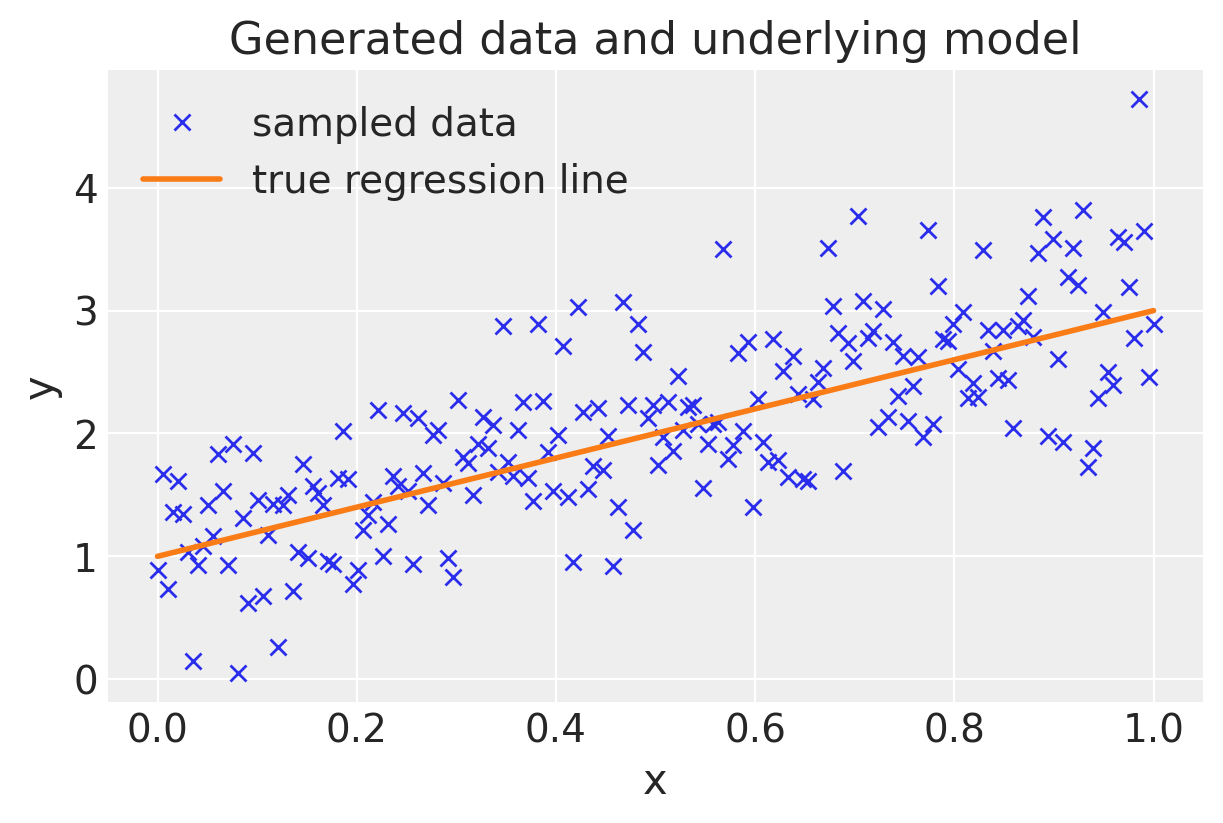

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [ ]:
with pm.Model() as glm_0:
    sigma = pm.HalfNormal("sigma", sigma=10)
    intercept = pm.Normal("intercept", 0, sigma=10)
    slope = pm.Normal("slope", 0, sigma=10)

    obs = pm.Normal("obs", mu=intercept+slope*x, sigma=sigma, observed=y)
    step = pm.NUTS()
    trace_0 = pm.sample(3000, tune=2000, step=step, chains=4, progressbar=True)

Output()

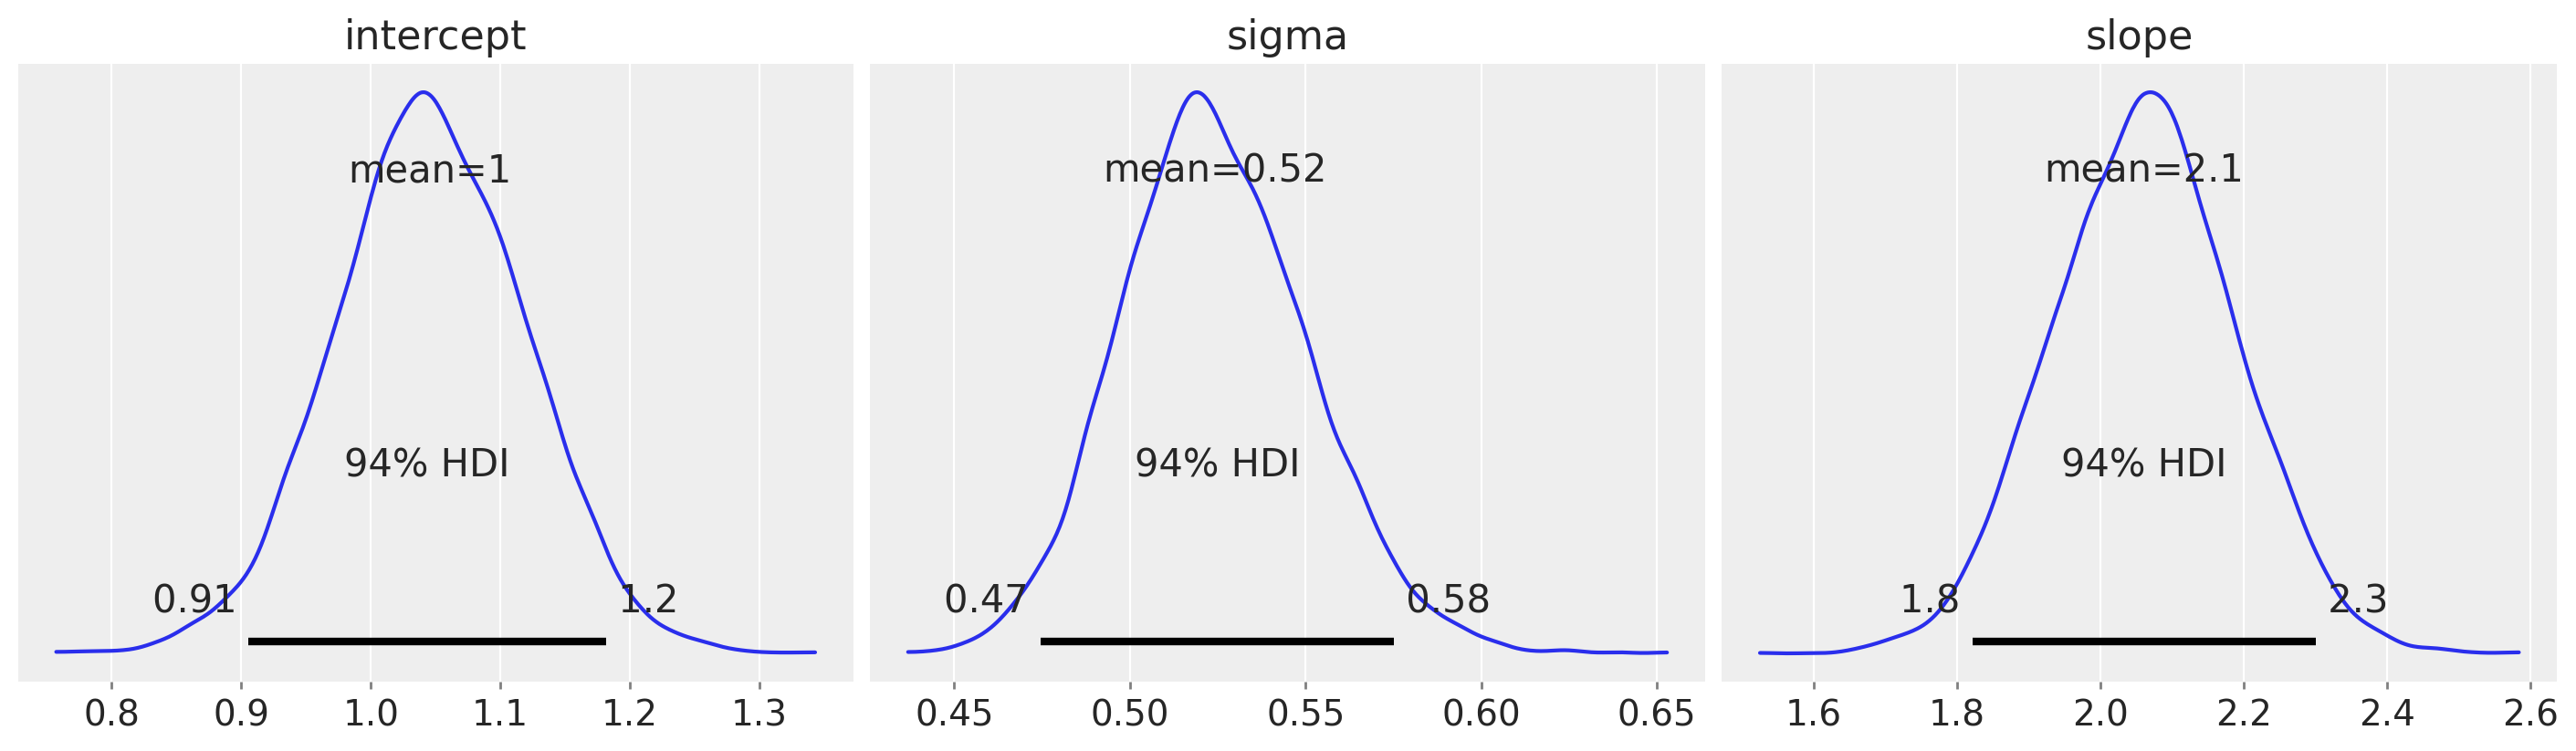

In [ ]:
az.plot_posterior(trace_0, var_names=['intercept', 'sigma', 'slope'], figsize=(14, 4))
plt.show()
plt.close()

/tmp/ipython-input-726957368.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred_flat, hdi_prob=0.94)


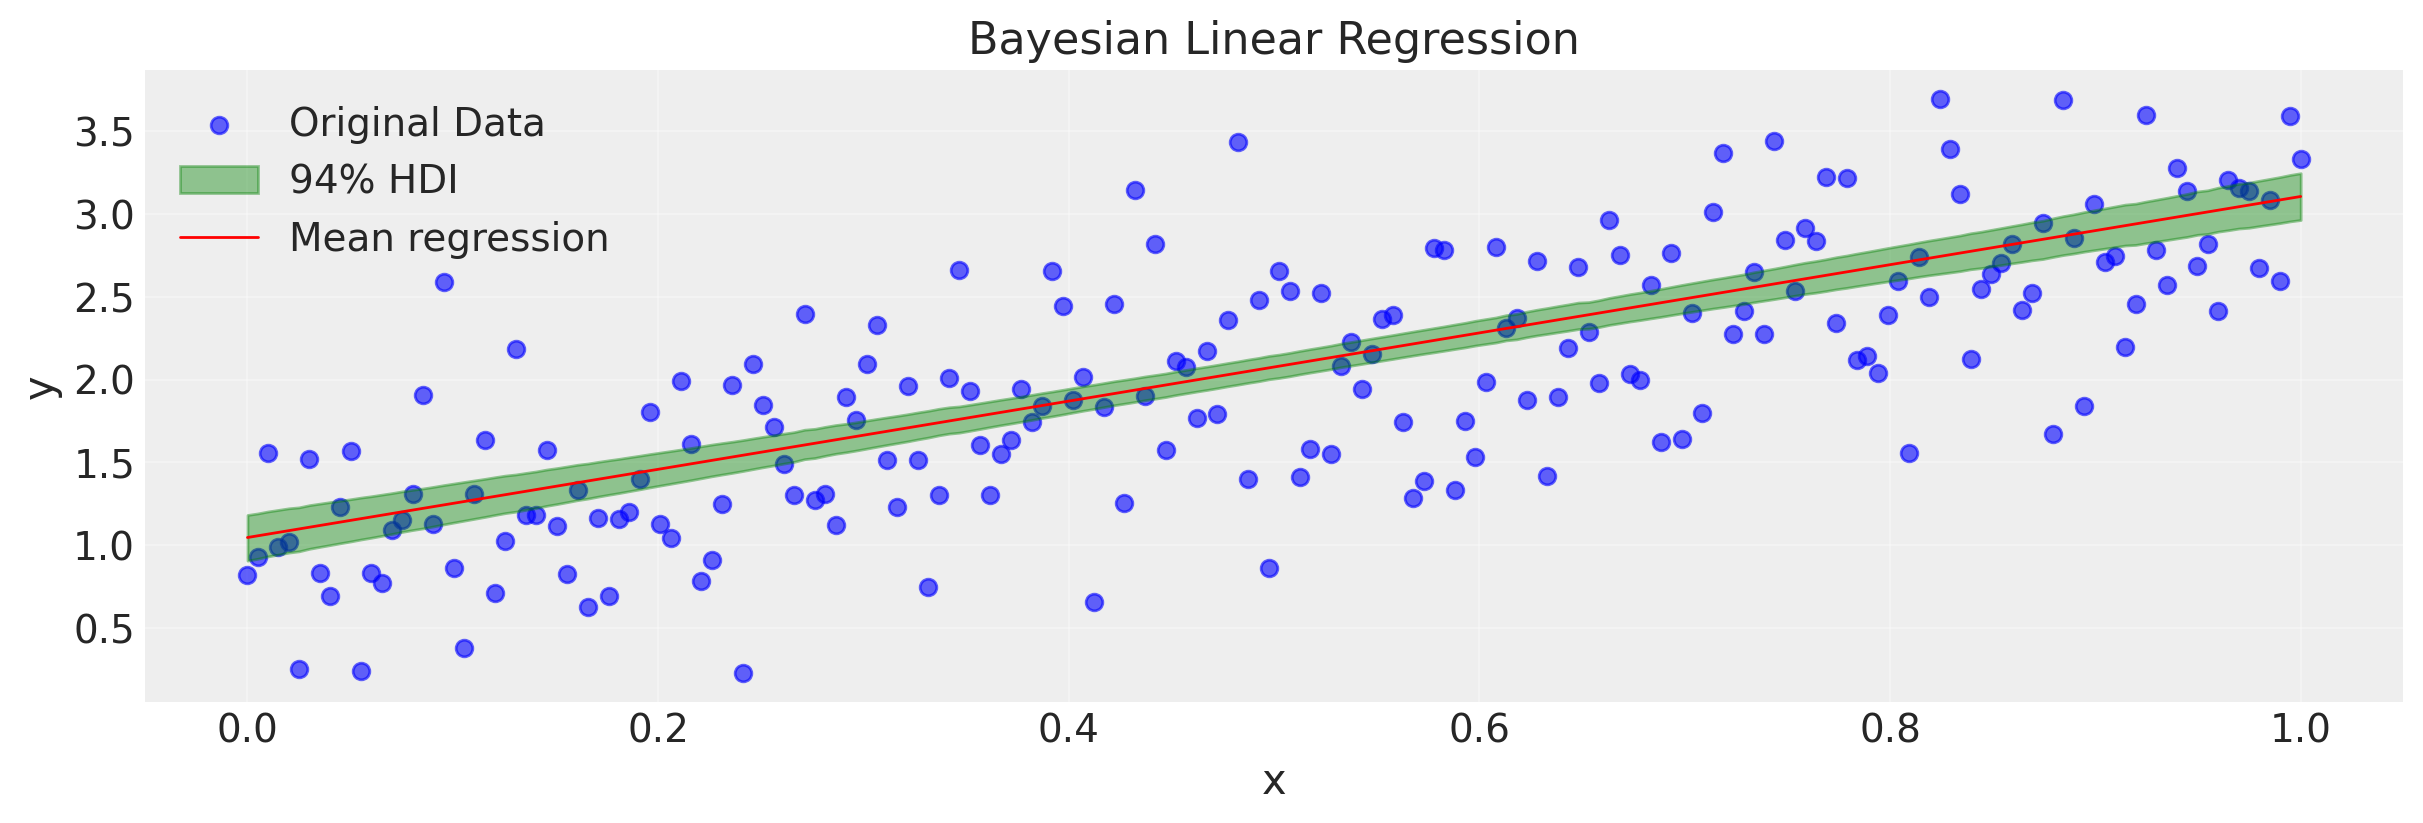

In [ ]:
posterior = trace_0.posterior

y_pred = (
    posterior["intercept"].values[..., None] +
    posterior["slope"].values[..., None] * x
)

y_pred_flat = y_pred.reshape(-1, size)

y_mean = y_pred_flat.mean(axis=0)

hdi = az.hdi(y_pred_flat, hdi_prob=0.94)
hdi_lower, hdi_upper = hdi[:, 0], hdi[:, 1]

plt.figure(figsize=(12, 4))
plt.scatter(x, y, color="blue", alpha=0.6, label="Original Data")

plt.fill_between(x, hdi_lower, hdi_upper, color="green", alpha=0.4, label="94% HDI")

plt.plot(x, y_mean, color="red", lw=1, label="Mean regression")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Bayesian Linear Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Exercises

##Exercise 1

Consider the following formulation for a GLM:

$Y_i|X_i, \theta \sim Dist(f(X_i; \theta))$

We are provided with a dataset about students in college with two columns $x$ and $y$ and we know that $x$ represents the number of hours studied by students. Find a valid distribution $Dist$ for the following cases:

(a) $Y$ is pass or fail after the exam.

(b) $Y$ is the final grade they achieve in the course.

(c) $Y$ is how many correct answers they provide out of 20 during the multiple choice exam.

(d) $Y$ is the time they spend for an exercise during the multiple choice exam.

(e) $Y$ is the amount of practice exercises they did before the exam date.

## Exercise 2

You are given the results of monitoring stress and skincare for patients suffering from a condition which manifests rashes on their skin. We **assume** (probably incorrectly) that:

* the rashes appear at a constant rate in a week
* the more stressed a person is, the more rashes they have
* the more prescribed skincare a person uses, the more they treat the rash
* the patients develop multiple rashes in a week and they are recorded in the dataset
* the records mention being stressed and **NOT** using the skincare, both cases increasing the possibility of rashes appearing on the skin.

In the dataset rashes.csv you find this data aggregated per week (the number of rashes as int and not using skincare/being stressed as booleans). Using PyMC, model a GLM with an **interaction** term: $\beta_0+\beta_1x_1+\beta_2x_2+\beta_3x_1x_2$

You can validate your work with posterior predictive check: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#posterior-predictive

💡 hint: after loading the dataframe in a variable df, run in a cell:

`df.groupby(["noskincare", "stress"])["nrashes"].agg(["mean", "var"])`

The mean and variance for each case have a pattern, is there a distribution known for modeling **COUNT DATA** which has that specific attribute?


# Exercise 3

You are given a dataset of two measurements and their corresponding label in both train and test splits: (f_train.csv, f_test.csv). Using PyMC, develop a generative story for the label given the train measurements and use the posterior distributions to predict the test labels. Validate your model using the accuracy metric on the test set.

💡 hint: plot the train samples with their label and use your intuition for a decision boundary
